In [1]:
import os
from galileo.handlers.langchain import GalileoCallback
from galileo import GalileoDecorator

os.environ["GALILEO_PROJECT"] = "demo-simple-agent-langgraph"
os.environ["GALILEO_LOG_STREAM"]="dev"

os.environ["LANGCHAIN_PROJECT"]="galileo-demo-simple-agent-langgraph"

# Create a callback with the custom logger
galileo_v2_callback = GalileoCallback(
    start_new_trace=True,   # Whether to start a new trace for each chain
    flush_on_chain_end=True # Whether to flush traces when chains end
) 
galileo_context = GalileoDecorator()

from braintrust import init_logger
from braintrust_langchain import BraintrustCallbackHandler

init_logger(project="galileo-simple-agent-langgraph", api_key=os.environ.get("BRAINTRUST_API_KEY"))
braintrust_callback = BraintrustCallbackHandler()

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [3]:
from dotenv import load_dotenv

load_dotenv("../.env")

True

In [4]:
import nest_asyncio
nest_asyncio.apply()
import asyncio

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain_core.tools import BaseTool, StructuredTool, Tool
from typing import Any, Dict, Optional, Union, Callable

llm = init_chat_model("openai:gpt-4.1", callbacks=[galileo_v2_callback, braintrust_callback])

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

math_server_path = "/Users/sid/Desktop/galileo/sdk-examples/python/mcp/example_math_server.py"
weather_server_path = "/Users/sid/Desktop/galileo/sdk-examples/python/mcp/example_weather_server.py"

# def create_async_to_sync_wrapper(async_tool: BaseTool) -> BaseTool:
#     """Results in:

#     What is 23 times 43?
#     ================================== Ai Message ==================================
#     Tool Calls:
#     multiply (call_GKQvF422F0rxYDz5Se7IR0hB)
#     Call ID: call_GKQvF422F0rxYDz5Se7IR0hB
#     Args:
#         __arg1: 23*43
#     ================================= Tool Message =================================
#     Name: multiply

#     Error: TypeError('create_async_to_sync_wrapper.<locals>.sync_func() takes 0 positional arguments but 1 was given')
#     Please fix your mistakes.
#     ================================== Ai Message ==================================
#     Tool Calls:
#     multiply (call_qxAPCoNIVi1zwpceYZHqFR2W)
#     Call ID: call_qxAPCoNIVi1zwpceYZHqFR2W
#     Args:
#         __arg1: 23
#     ================================= Tool Message =================================
#     Name: multiply

#     Error: TypeError('create_async_to_sync_wrapper.<locals>.sync_func() takes 0 positional arguments but 1 was given')
#     Please fix your mistakes.
#     ================================== Ai Message ==================================

#     I made an error in formatting the input for multiplication. Let me correct that and calculate 23 times 43 for you.
#     Tool Calls:
#     multiply (call_SME9y7xAtQ7T2g46p6rQYQ3j)
#     Call ID: call_SME9y7xAtQ7T2g46p6rQYQ3j
#     Args:
#         __arg1: 23,43
#     ================================= Tool Message =================================
#     Name: multiply

#     Error: TypeError('create_async_to_sync_wrapper.<locals>.sync_func() takes 0 positional arguments but 1 was given')
#     Please fix your mistakes.
#     """
    
#     # Create sync function that correctly packages arguments for ainvoke
#     def sync_func(**kwargs) -> Any:
#         loop = asyncio.get_event_loop()
        
#         # Remove callbacks if present
#         input_dict = {k: v for k, v in kwargs.items() if k != 'callbacks'}
        
#         # Call ainvoke with the properly formatted input parameter
#         try:
#             if hasattr(async_tool, 'ainvoke') and callable(async_tool.ainvoke):
#                 # This is the key fix - ainvoke expects a single 'input' parameter 
#                 # that contains the dictionary of arguments
#                 return loop.run_until_complete(async_tool.ainvoke(input=input_dict))
#             else:
#                 raise ValueError(f"Tool {async_tool.name} doesn't have an ainvoke method")
#         except Exception as e:
#             return f"Error executing {async_tool.name}: {str(e)}"
    
#     # Always use a basic Tool for wrapper - this avoids schema issues
#     return Tool(
#         name=async_tool.name,
#         description=async_tool.description,
#         func=sync_func
#     )


# def create_async_to_sync_wrapper(async_tool: BaseTool) -> BaseTool:
#     """Results in:
#     What is 23 times 43?
#     ================================== Ai Message ==================================
#     Tool Calls:
#     multiply (call_8RgKaCBTj6Oh4br1dm1qq67s)
#     Call ID: call_8RgKaCBTj6Oh4br1dm1qq67s
#     Args:
#         __arg1: 23 times 43
#     ================================= Tool Message =================================
#     Name: multiply

#     Error: TypeError('create_async_to_sync_wrapper.<locals>.sync_func() takes 0 positional arguments but 1 was given')
#     Please fix your mistakes.
#     """
    
#     def sync_func(**kwargs):
#         loop = asyncio.get_event_loop()
#         try:
#             return loop.run_until_complete(async_tool.ainvoke(input=kwargs))
#         except Exception as e:
#             return f"Error executing {async_tool.name}: {str(e)}"
    
#     return Tool(
#         name=async_tool.name,
#         description=async_tool.description,
#         func=sync_func
#     )

# def create_async_to_sync_wrapper(async_tool: BaseTool) -> BaseTool:
#     """Results in:

#     What is 23 times 43?
#     ================================== Ai Message ==================================
#     Tool Calls:
#     multiply (call_ZKmc4zZcc9AsoBExfRAP8zk0)
#     Call ID: call_ZKmc4zZcc9AsoBExfRAP8zk0
#     Args:
#         __arg1: 23 43
#     Tool multiply called with args: ('23 43',), kwargs: {}
#     ================================= Tool Message =================================
#     Name: multiply

#     Error: Tool multiply execution timed out
#     ================================== Ai Message ==================================
#     Tool Calls:
#     multiply (call_I9EpBlzkEQnDflJoueGi7dmr)
#     Call ID: call_I9EpBlzkEQnDflJoueGi7dmr
#     Args:
#         __arg1: 23
#     Tool multiply called with args: ('23',), kwargs: {}
#     ================================= Tool Message =================================
#     Name: multiply

#     Error: Tool multiply execution timed out
#     """
    
#     def sync_func(*args, **kwargs):
#         # Print args and kwargs for debugging
#         print(f"Tool {async_tool.name} called with args: {args}, kwargs: {kwargs}")
        
#         # For LangGraph compatibility, accept both positional and keyword arguments
#         # But convert to a proper input dictionary for ainvoke
#         if args and len(args) == 1 and isinstance(args[0], dict):
#             # If first argument is a dict, use it as the input
#             input_dict = args[0]
#         else:
#             # Otherwise use kwargs as the input
#             input_dict = kwargs
        
#         # Remove callbacks to avoid serialization issues
#         if 'callbacks' in input_dict:
#             input_dict = {k: v for k, v in input_dict.items() if k != 'callbacks'}
            
#         # Get the event loop
#         loop = asyncio.get_event_loop()
        
#         try:
#             # Call the async tool with the input dictionary
#             coro = async_tool.ainvoke(input=input_dict)
#             result = loop.run_until_complete(
#                 asyncio.wait_for(coro, timeout=5.0)
#             )
#             return result
#         except asyncio.TimeoutError:
#             return f"Error: Tool {async_tool.name} execution timed out"
#         except Exception as e:
#             # Use a simplified error message for clarity
#             error_msg = f"Error executing {async_tool.name}: {type(e).__name__} - {str(e)}"
#             print(error_msg)
#             return error_msg
    
#     # Create a basic Tool with the sync function
#     return Tool(
#         name=async_tool.name,
#         description=async_tool.description,
#         func=sync_func
#     )


# def create_async_to_sync_wrapper(async_tool: BaseTool) -> BaseTool:
#     """Results in:

#     What is 23 times 43?
#     ================================== Ai Message ==================================
#     Tool Calls:
#     multiply (call_u19OA3uNqsyFrMJ15oNyP1GS)
#     Call ID: call_u19OA3uNqsyFrMJ15oNyP1GS
#     Args:
#         __arg1: 23 43
#     ================================= Tool Message =================================
#     Name: multiply

#     Error: AttributeError("'dict' object has no attribute 'schema'")
#     Please fix your mistakes.
#     """
    
#     def sync_func(*args, **kwargs):
#         # Process inputs - handle both dict as first arg (from ToolNode) and kwargs
#         input_dict = {}
        
#         # If we got a dictionary as first positional arg (LangGraph style)
#         if args and len(args) == 1 and isinstance(args[0], dict):
#             input_dict.update(args[0])
#         # Otherwise use keyword arguments
#         else:
#             input_dict.update(kwargs)
            
#         # Remove callbacks to avoid serialization issues
#         if 'callbacks' in input_dict:
#             input_dict.pop('callbacks')
            
#         # Get schema properties to extract param names if available
#         arg_names = []
#         if hasattr(async_tool, 'args_schema'):
#             schema = async_tool.args_schema.schema()
#             if 'properties' in schema:
#                 arg_names = list(schema['properties'].keys())
                
#         # Extract values from __arg parameters and map to schema params
#         for key in list(input_dict.keys()):
#             if key.startswith('__arg') and arg_names:
#                 value = input_dict.pop(key)
#                 # Try to find the correct parameter by index
#                 index = 0
#                 try:
#                     # Extract number from __arg1, __arg2, etc.
#                     arg_num = int(key.replace('__arg', ''))
#                     index = arg_num - 1  # Convert to 0-based index
#                 except (ValueError, IndexError):
#                     pass
                
#                 # If we have a valid index and there's a matching parameter name
#                 if 0 <= index < len(arg_names):
#                     input_dict[arg_names[index]] = value
        
#         # Get event loop
#         loop = asyncio.get_event_loop()
        
#         try:
#             # Call the async tool with the input dictionary
#             if hasattr(async_tool, 'ainvoke') and callable(async_tool.ainvoke):
#                 return loop.run_until_complete(
#                     asyncio.wait_for(async_tool.ainvoke(input=input_dict), timeout=5.0)
#                 )
#             else:
#                 return f"Error: {async_tool.name} doesn't have an ainvoke method"
#         except asyncio.TimeoutError:
#             return f"Error executing {async_tool.name}: Operation timed out"
#         except Exception as e:
#             return f"Error executing {async_tool.name}: {str(e)}"
    
#     # Create a basic Tool with the sync function
#     return Tool(
#         name=async_tool.name,
#         description=async_tool.description,
#         func=sync_func
#     )

# def create_async_to_sync_wrapper(async_tool: BaseTool) -> BaseTool:
#     """Results in:

#     What is the weather in New York?
#     ================================== Ai Message ==================================
#     Tool Calls:
#     get_weather (call_0FMbHBblnQlvlpDdVR1PGYcO)
#     Call ID: call_0FMbHBblnQlvlpDdVR1PGYcO
#     Args:
#         location: New York
#     ================================= Tool Message =================================
#     Name: get_weather

#     Error executing get_weather: Operation timed out
#     """
    
#     def sync_func(*args, **kwargs):
#         # Handle both direct calls and calls via LangGraph's ToolNode
#         input_dict = {}
        
#         # If called with a dictionary as first positional argument (LangGraph pattern)
#         if args and len(args) == 1 and isinstance(args[0], dict):
#             input_dict = args[0]
#         else:
#             input_dict = kwargs
        
#         # Remove callbacks if present
#         if 'callbacks' in input_dict:
#             input_dict.pop('callbacks')
        
#         # Get event loop
#         loop = asyncio.get_event_loop()
        
#         try:
#             # Pass the input dictionary to the tool's ainvoke method
#             if hasattr(async_tool, 'ainvoke') and callable(async_tool.ainvoke):
#                 return loop.run_until_complete(
#                     asyncio.wait_for(async_tool.ainvoke(input=input_dict), timeout=5.0)
#                 )
#             else:
#                 return f"Error: {async_tool.name} doesn't have an ainvoke method"
#         except asyncio.TimeoutError:
#             return f"Error executing {async_tool.name}: Operation timed out"
#         except Exception as e:
#             return f"Error executing {async_tool.name}: {str(e)}"
    
#     # Here's the key improvement - create a structured tool that preserves the schema
#     # This ensures the LLM gets proper parameter information
#     return StructuredTool.from_function(
#         func=sync_func,
#         name=async_tool.name,
#         description=async_tool.description,
#         args_schema=async_tool.args_schema if hasattr(async_tool, "args_schema") else None
#     )

# def create_async_to_sync_wrapper(async_tool: BaseTool) -> BaseTool:
#     """Create a synchronous wrapper for an async tool that handles LangGraph's calling convention."""
    
#     def sync_func(*args, **kwargs):
#         # Handle both direct calls and calls via LangGraph's ToolNode
#         input_dict = {}
        
#         # If called with a dictionary as first positional argument (LangGraph pattern)
#         if args and len(args) == 1 and isinstance(args[0], dict):
#             input_dict = args[0]
#         else:
#             input_dict = kwargs
        
#         # Remove callbacks if present
#         if 'callbacks' in input_dict:
#             input_dict.pop('callbacks')
        
#         # Print debug info
#         print(f"Tool {async_tool.name} called with input: {input_dict}")
        
#         # Instead of trying to call the async version which is timing out,
#         # implement the math functions directly
#         if async_tool.name == "multiply" and "a" in input_dict and "b" in input_dict:
#             try:
#                 return int(input_dict["a"]) * int(input_dict["b"])
#             except (ValueError, TypeError):
#                 return f"Error: parameters must be numbers, got a={input_dict['a']}, b={input_dict['b']}"
        
#         elif async_tool.name == "add" and "a" in input_dict and "b" in input_dict:
#             try:
#                 return int(input_dict["a"]) + int(input_dict["b"])
#             except (ValueError, TypeError):
#                 return f"Error: parameters must be numbers, got a={input_dict['a']}, b={input_dict['b']}"
        
#         elif async_tool.name == "get_weather" and "location" in input_dict:
#             return f"It's sunny in {input_dict['location']}"
        
#         else:
#             return f"Unsupported operation or missing parameters for {async_tool.name}"
    
#     # Create a tool that preserves the name and description
#     return Tool(
#         name=async_tool.name,
#         description=async_tool.description,
#         func=sync_func
#     )

# def create_async_to_sync_wrapper(async_tool: BaseTool) -> BaseTool:
#     """Create a synchronous wrapper for an async tool."""
    
#     def sync_func(*args, **kwargs):
#         # Handle both positional dictionary (from LangGraph) and keyword args
#         input_dict = {}
        
#         # If called with a dict as first arg (LangGraph pattern)
#         if args and len(args) == 1 and isinstance(args[0], dict):
#             input_dict = args[0]
#         else:
#             input_dict = kwargs
        
#         # Map __arg1 to the first parameter if needed
#         if '__arg1' in input_dict and hasattr(async_tool, 'args_schema'):
#             schema = async_tool.args_schema.schema()
#             if 'properties' in schema and schema['properties']:
#                 # Get the first parameter name
#                 first_param = next(iter(schema['properties'].keys()))
#                 input_dict[first_param] = input_dict.pop('__arg1')
        
#         # Get event loop
#         loop = asyncio.get_event_loop()
        
#         try:
#             # Use .invoke instead of .ainvoke for debugging
#             # This directly uses the same interface that would be called when using the tool normally
#             return loop.run_until_complete(
#                 asyncio.wait_for(async_tool.ainvoke(input=input_dict), timeout=10.0)
#             )
#         except asyncio.TimeoutError:
#             return f"Error: Tool {async_tool.name} timed out after 10 seconds"
#         except Exception as e:
#             return f"Error executing {async_tool.name}: {str(e)}"
    
#     # Create a basic Tool
#     return Tool(
#         name=async_tool.name,
#         description=async_tool.description,
#         func=sync_func
#     )

def create_async_to_sync_wrapper(async_tool: BaseTool) -> BaseTool:
    """Create a synchronous wrapper for an async tool that avoids blocking."""
    
    def sync_func(*args, **kwargs):
        # Handle both positional dictionary (from LangGraph) and keyword args
        input_dict = {}
        
        # If called with a dict as first arg (LangGraph pattern)
        if args and len(args) == 1 and isinstance(args[0], dict):
            input_dict = args[0].copy()
        else:
            input_dict = kwargs.copy()
        
        # Map __arg1 to the first parameter if needed
        if '__arg1' in input_dict and hasattr(async_tool, 'args_schema'):
            schema = async_tool.args_schema.schema()
            if 'properties' in schema and schema['properties']:
                # Get the first parameter name
                first_param = next(iter(schema['properties'].keys()))
                input_dict[first_param] = input_dict.pop('__arg1')
        
        print(f"Executing {async_tool.name} with input: {input_dict}")
        
        # Create a dedicated event loop for this tool call
        tool_loop = asyncio.new_event_loop()
        
        try:
            # Run the tool in the dedicated loop
            result = tool_loop.run_until_complete(
                asyncio.wait_for(
                    async_tool.ainvoke(input=input_dict),
                    timeout=5.0
                )
            )
            print(f"Tool {async_tool.name} result: {result}")
            return result
        except asyncio.TimeoutError:
            print(f"Tool {async_tool.name} timed out")
            return f"Error: Tool {async_tool.name} timed out after 5 seconds"
        except Exception as e:
            print(f"Tool {async_tool.name} error: {type(e).__name__}: {e}")
            return f"Error executing {async_tool.name}: {str(e)}"
        finally:
            # Properly close the event loop to free resources
            tool_loop.close()
    
    return Tool(
        name=async_tool.name,
        description=async_tool.description,
        func=sync_func
    )

async def setup_mcp():
    client = MultiServerMCPClient(
        {
            "math": {
                "command": "python",
                "args": [math_server_path],
                "transport": "stdio",
            },
            "weather": {
                "url": "http://localhost:8000/sse",
                "transport": "sse",
            }
        }
    )
    print("Initialized client")
    await client.__aenter__()
    
    # Get the async MCP tools
    async_mcp_tools = client.get_tools()
    print(f"Obtained async tools {async_mcp_tools}")
    
    # Convert each async tool to a sync wrapper using our fixed function
    sync_mcp_tools = [create_async_to_sync_wrapper(tool) for tool in async_mcp_tools]
    
    return client, sync_mcp_tools

# Run the async setup function
loop = asyncio.get_event_loop()
mcp_client, mcp_tools = loop.run_until_complete(setup_mcp())

# Combine all tools
tavily_tool = TavilySearch(max_results=2)
tools = [tavily_tool, human_assistance] + mcp_tools
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Disable parallel tool calling to avoid repeating tool invocations when we resume
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

Initialized client
Obtained async tools [StructuredTool(name='add', description='Add two numbers.\n    \n    Args:\n        a: The first number to add\n        b: The second number to add\n        \n    Returns:\n        The sum of a and b\n        \n    Examples:\n        To add 5 and 3, provide a=5, b=3\n    ', args_schema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'addArguments', 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x158bf9d00>), StructuredTool(name='multiply', description='Multiply two numbers.\n    \n    Args:\n        a: The first number to multiply\n        b: The second number to multiply\n        \n    Returns:\n        The product of a and b\n        \n    Examples:\n        To multiply 5 and 3, provide a=5, b=3. Do not use expressions like "5*3".\n    ', args_schema={'properties': {'a': {'ti

In [5]:
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)

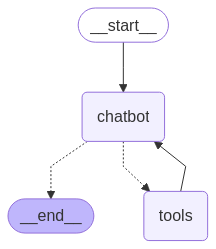

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("Something went wrong while trying to display the graph.")
    pass

In [7]:
config = {"configurable": {"thread_id": "1"}}

def stream_with_interrupt_handling():
    while True:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        
        # Start streaming the response
        events = graph.stream(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
            stream_mode="values",
        )
        
        # Process events until we hit an interrupt or complete
        for event in events:
            if "messages" in event:
                event["messages"][-1].pretty_print()
        
        # After streaming completes, check if we hit an interrupt
        snapshot = graph.get_state(config)
        
        # Check if the graph is at an interrupt
        if snapshot.next:
            assert snapshot.next[0] == "tools", f"Unexpected value for snapshot.next: {snapshot.next}"
            # We're at an interrupt - get human input
            print("\n[System: Agent is requesting human assistance]")
            
            # Extract the query from the interrupt state
            interrupt_msg = None
            for msg in reversed(snapshot.values["messages"]):
                if hasattr(msg, "tool_calls") and msg.tool_calls:
                    for tool_call in msg.tool_calls:
                        if tool_call["name"] == "human_assistance":
                            interrupt_msg = tool_call["args"]["query"]
                            break
                    if interrupt_msg:
                        break
            
            if interrupt_msg:
                print(f"[Agent query: {interrupt_msg}]")
            
            # Get human response
            human_response = input("Human: ")
            
            # Resume with the human response
            human_command = Command(resume={"data": human_response})
            
            # Continue streaming from where we left off
            events = graph.stream(human_command, config, stream_mode="values")
            for event in events:
                if "messages" in event:
                    event["messages"][-1].pretty_print()


In [8]:
# snapshot = graph.get_state(config)
# print(snapshot)

stream_with_interrupt_handling()

================================ Human Message =================================

What is the weather in London?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_VkP2PjxiHXtX7dnO9tBue9vb)
 Call ID: call_VkP2PjxiHXtX7dnO9tBue9vb
  Args:
    __arg1: London
Executing get_weather with input: {}
Tool get_weather timed out
================================= Tool Message =================================
Name: get_weather

Error: Tool get_weather timed out after 5 seconds
================================== Ai Message ==================================

I apologize, but I'm currently unable to retrieve the latest weather information for London due to a technical issue. Would you like me to try again or provide some general information about the typical weather in London?
Goodbye!
